In [33]:
import findspark
findspark.init('C:\\Users\\vivia\\spark-3.0.0-preview2-bin-hadoop2.7')
import pyspark
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SQLContext

sc = pyspark.SparkContext()
     # .setLogLevel('WARN')
conf = SparkConf()
conf.set("spark.driver.memory", "35g")
conf.set("spark.executor.memory", "50g")
conf.set("spark.memory.fraction","0.1")
conf.set("spark.executor.heartbeatInterval",'3600s')
conf.set("spark.network.timeout", "15000s")
conf.set("spark.driver.maxResultSize","25g")
#conf.set("spark.sql.autoBroadcastJoinThreshold", "-1")
#conf.set("spark.cleaner.periodicGC.interval","15min")
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("NLP Project") \
    .getOrCreate()

In [32]:
sc.stop()

In [34]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import spacy
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import ArrayType
import json

# Function to Compare Lambda

In [3]:
from pyspark.sql.types import FloatType
from matplotlib.ticker import (MultipleLocator, MaxNLocator)
def get_prediction(filepath,dataset_type,num_topics, alpha):
    topicdist_file = "new_df"+str(i+1)+"_"+str(num_topics)+"topics.csv"
    ts_train_file = "df_train"+str(i+1)+dataset_type+".csv"
    ts_fcast_file = "pred_dataset"+str(i+1)+dataset_type+".csv"
    test_topicdist_file = "df_lm"+str(i+1)+".csv"
    
    
    df_topicdist = spark.read\
            .option("header",'true')\
            .csv(filepath+topicdist_file)
    
    df_fit = df_topicdist.groupBy(['date','change']).agg(collect_list("col").alias('topicDistribution'))
    
    #include avg change in dataframe with topic distribution
    df_ts = spark.read\
    .option("header",'true')\
    .csv(filepath+ts_train_file)
    df_ts = df_ts.select('date',exp("log_change").alias('Y_change'))    
    
    #combine avg_change with topic distribution vector
    to_vect = udf(lambda vs: Vectors.dense(vs), VectorUDT())
    df_lm = df_fit.withColumn('topicDistribution',to_vect('topicDistribution')).select('date','change','topicDistribution')
    df_lm = df_lm.withColumn("change", df_lm["change"].cast(FloatType()))
    
    #fit regression model        
    lr=LinearRegression(featuresCol="topicDistribution", labelCol="change", maxIter=100,
    regParam=alpha, elasticNetParam=1.0)
    lr_model = lr.fit(df_lm)
      
    #prepare test set
    r_pred = spark.read\
            .option("header",'true')\
            .csv(filepath+ts_fcast_file)

    r_pred_df = r_pred.select("date",exp("Y_pred").alias("Y_pred"),exp('Y_test').alias("change"))
    avg_change_test_rows = r_pred_df.select(avg('Y_pred')).collect()
    avg_change_test = avg_change_test_rows[0]['avg(Y_pred)']


    #import test set data
    df_test = spark.read\
        .option("header",'true')\
        .csv(filepath+test_topicdist_file)

    df_test = df_test.groupBy(['date','change']).agg(collect_list("col").alias('topicDistribution'))
    to_vect = udf(lambda vs: Vectors.dense(vs), VectorUDT())
    df_lm_test = df_test.withColumn('topicDistribution',to_vect('topicDistribution')).select('date','change','topicDistribution')
    df_lm_test = df_lm_test.withColumn("change", df_lm_test["change"].cast(FloatType()))
    
    #get prediction and plot
    pred_df_ps = lr_model.transform(df_lm_test)
    lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                     labelCol="change",metricName="rmse")
    print("RMSE on test data "+str(i+1)+" = %g" % lr_evaluator.evaluate(pred_df_ps))
    
    #convert pyspark dataframe to pandas dataframe to plot predictions
    pred_df = pred_df_ps.select("*").toPandas()
    pred_df['prediction'] = pred_df['prediction'].astype('float64')
    pred_df['change'] = pred_df['change'].astype('float32')
    df_plot = pred_df.sort_values('date').reset_index().drop(columns='index')
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.xaxis.set_major_locator(MaxNLocator())
    plt.xticks(rotation=90)
    ax.plot(df_plot['date'],df_plot['prediction'])
    ax.plot(df_plot['date'],df_plot['change'])
    plt.title('Lamda: '+str(alpha)+" Dataset "+str(i+1))
    plt.show()


## Function to calculate the number of peaks explained

In [4]:
def calc_peaks_explained(df_pred,ts_pred_df):
    results_df = df_pred.select('date','prediction','change').join(ts_pred_df.select('date','Y_pred'), on=['date'], how='left_outer')
    avg_change = results_df.select(avg('change')).collect()[0]['avg(change)']
    results_df = results_df.withColumn('avg_change',lit(avg_change))
    std_dev = results_df.select(stddev('change')).collect()[0]['stddev_samp(change)']
    
    #define peaks as days where the change in volume is greater than 0.5*standard deviation of the test set change
    results_df_2 = results_df.withColumn("lower_bound",col("avg_change")-0.5*std_dev)
    results_df_2 = results_df_2.withColumn("upper_bound",col("avg_change")+0.5*std_dev)
  
    #if the prediction and actual change are of opposite directions, then the peak is considered as "not explained"
    #if the prediction exceeds the actual change by more than 20%, the peak is also "not explained"
    #otherwise, % explained is in relation to time series prediction
    peak_days = results_df_2.where((col('change')>col('upper_bound')) | (col('change')<col('lower_bound')))
    peaks_explained = peak_days.withColumn('% explained',when(
             ((col('prediction') < '1') & (col('change') > '1'))
            | ((col('prediction') > '1') & (col('change') < '1')) 
            |((col('prediction') < '1') & (col('change') < '1') & (((col('change')-col('prediction'))/abs(col('change')-col('Y_pred'))) > 0.2))
            |((col('prediction') > '1') & (col('change') > '1') & (((col('prediction')-col('change'))/abs(col('change')-col('Y_pred'))) > 0.2))
            , 0
             ).otherwise(abs(col('prediction')-col('Y_pred'))/abs(col('change')-col('Y_pred'))))
    peaks_explained_count = peaks_explained.withColumn("count_explained",when(col('% explained')>0.20,1).otherwise(0))
    num_peaks = peak_days.count()

    return peaks_explained_count,peaks_explained_count.select((sum('count_explained')/count('*')).alias('peaks_explained')).collect()[0]['peaks_explained'],num_peaks


    

## Print all metrics for training and test set

In [5]:
from pyspark.sql.types import FloatType
from matplotlib.ticker import (MultipleLocator, MaxNLocator)
def get_metrics(filepath,dataset_type,num_topics, alpha):
    topicdist_file = "new_df"+str(i+1)+"_"+str(num_topics)+"topics.csv"
    ts_train_file = "df_train"+str(i+1)+dataset_type+".csv"
    ts_fcast_file = "pred_dataset"+str(i+1)+dataset_type+".csv"
    test_topicdist_file = "df_lm"+str(i+1)+".csv"
        
    df_topicdist = spark.read\
            .option("header",'true')\
            .csv(filepath+topicdist_file)
    
    df_fit = df_topicdist.groupBy(['date','change']).agg(collect_list("col").alias('topicDistribution'))
    
    #include avg change in dataframe with topic distribution
    df_ts = spark.read\
    .option("header",'true')\
    .csv(filepath+ts_train_file)
    df_ts = df_ts.select('date',exp("log_change").alias('Y_change'))    
    
    #combine avg_change with topic distribution vector
    to_vect = udf(lambda vs: Vectors.dense(vs), VectorUDT())
    df_lm = df_fit.withColumn('topicDistribution',to_vect('topicDistribution')).select('date','change','topicDistribution')
    df_lm = df_lm.withColumn("change", df_lm["change"].cast(FloatType()))
    
    #fit regression model        
    lr=LinearRegression(featuresCol="topicDistribution", labelCol="change", maxIter=100,
    regParam=alpha, elasticNetParam=1.0)
    lr_model = lr.fit(df_lm)    
    coeff = lr_model.coefficients
    non_zero_coeff = np.count_nonzero(coeff)
    trainingSummary = lr_model.summary
    print("Dataset" + str(i+1)+" RMSE: %f" % trainingSummary.rootMeanSquaredError)
    print("Dataset" + str(i+1)+" r2: %f" % trainingSummary.r2)
    print("Dataset" + str(i+1)+" non-zero coefficients:"+str(non_zero_coeff)+"\n")
    
    
    #prepare test set
    #time series prediction
    r_pred = spark.read\
            .option("header",'true')\
            .csv(filepath+ts_fcast_file)
    #transform log-change prediction to change prediction
    r_pred_df = r_pred.select("date",exp("Y_pred").alias("Y_pred"),exp('Y_test').alias("change"))

    #import test set data
    df_test = spark.read\
        .option("header",'true')\
        .csv(filepath+test_topicdist_file)

    df_test = df_test.groupBy(['date','change']).agg(collect_list("col").alias('topicDistribution'))
    to_vect = udf(lambda vs: Vectors.dense(vs), VectorUDT())
    df_lm_test = df_test.withColumn('topicDistribution',to_vect('topicDistribution')).select('date','change','topicDistribution')
    df_lm_test = df_lm_test.withColumn("change", df_lm_test["change"].cast(FloatType()))

    
    #get prediction
    pred_df_ps = lr_model.transform(df_lm_test)
    lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
    labelCol="change",metricName="rmse")
    df_peaks_explained,peaks_explained,num_peaks = calc_peaks_explained(pred_df_ps,r_pred_df)
    df_peaks_explained.show()
    
    print("RMSE on test data "+str(i+1)+" = %g" % lr_evaluator.evaluate(pred_df_ps))
    print("Peaks Explained on test data "+str(i+1)+" = %g" % peaks_explained)
    print("Number of peaks on test data "+str(i+1)+" "+str(num_peaks)+"\n")
    

## Function to plot predictions

In [313]:
def plot_predictions(pred_df_ps,r_pred_df,test_set_num):
    pred_df = pred_df_ps.select("*").toPandas() #convert LASSO predictions dataframe to pandas dataframe
    ts_pred_df = r_pred_df.select("*").toPandas() #convert time series prediction to pandas dataframe
    #convert number fields to float
    pred_df['LASSO prediction'] = pred_df['prediction'].astype('float64')
    pred_df['volume change'] = pred_df['change'].astype('float32')
    
    #sort values by date
    df_plot = pred_df.sort_values('date').reset_index().drop(columns='index')
    
    #plot predictions
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.xaxis.set_major_locator(MaxNLocator())
    plt.xticks(rotation=90)
    plt.xlabel('Date')
    plt.ylabel('Volume change')
    ax.plot(df_plot['date'],df_plot['LASSO prediction'])
    ax.plot(df_plot['date'],df_plot['volume change'])
    ax.plot(ts_pred_df['date'],ts_pred_df['time series prediction'])
    ax.legend(loc='upper left')
    sns.set()

    plt.title("Test Dataset "+str(test_set_num))
    plt.show()


RMSE on test data 1 = 0.188613


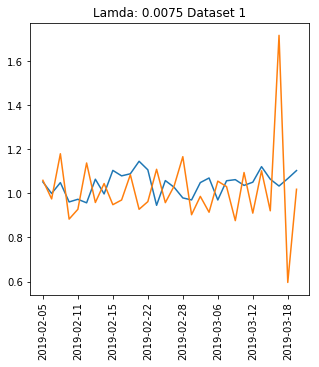

RMSE on test data 2 = 0.112651


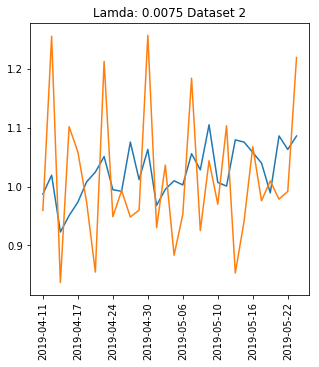

RMSE on test data 3 = 0.223538


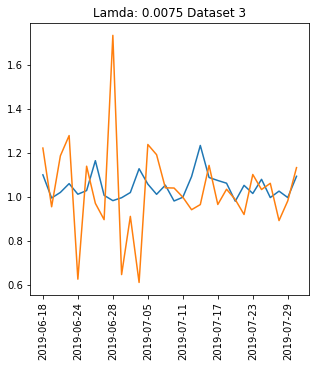

RMSE on test data 4 = 0.234236


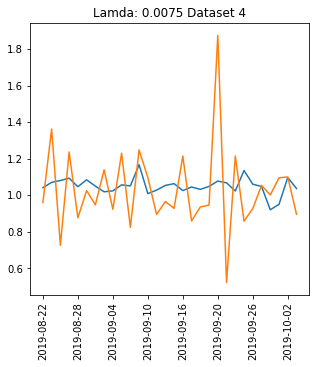

RMSE on test data 5 = 0.198677


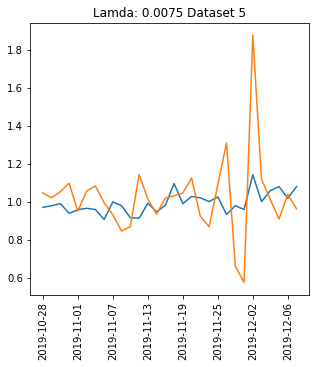

RMSE on test data 6 = 0.107324


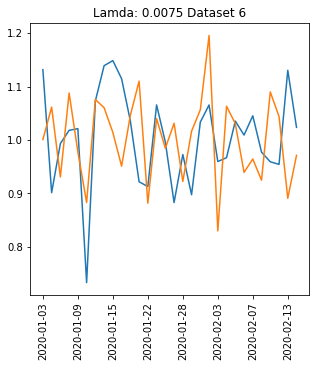

In [161]:
#compare prediction and actual change in volumes using lambda of 0.0075 and 150 topics
filepath = "C:\\Users\\vivia\\Documents\\MRP\\News NLP\\Topic Model\\Datasets 0.75year\\"
dataset_type = "_0.75year"
for i in range(6):
    get_prediction(filepath,dataset_type,alpha=0.0075)

RMSE on test data 1 = 0.176791


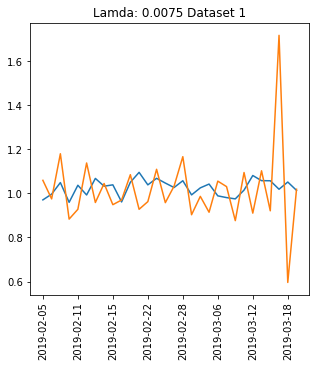

RMSE on test data 2 = 0.118176


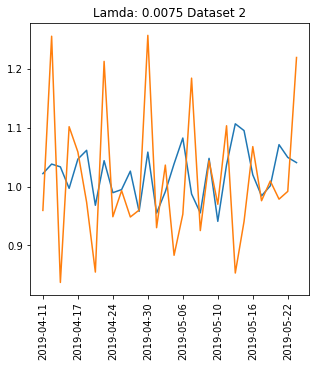

RMSE on test data 3 = 0.21414


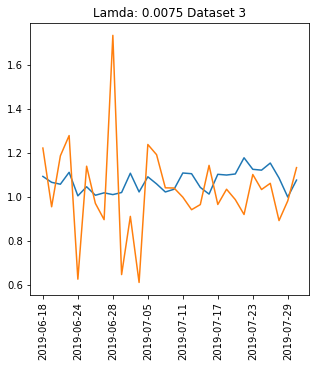

RMSE on test data 4 = 0.241448


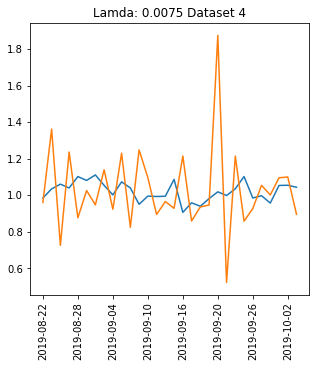

RMSE on test data 5 = 0.225826


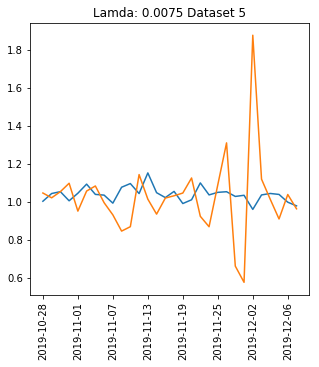

RMSE on test data 6 = 0.0892584


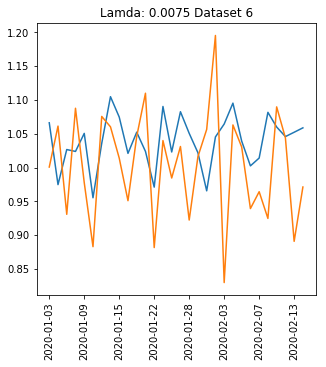

In [194]:
#compare prediction and actual change in volumes using lambda of 0.0075 and 100 topics
filepath = "C:\\Users\\vivia\\Documents\\MRP\\News NLP\\Topic Model\\Datasets 0.75year_100topics\\"
dataset_type = "_0.75year"
for i in range(6):
    get_prediction(filepath,dataset_type,num_topics=100,alpha=0.0075)

# Test lambdas for 150 topics

In [175]:
#peaks defined as 0.5*stddev above/below the mean
filepath = 'C:\\Users\\vivia\\Documents\\MRP\\News NLP\\Topic Model\\Datasets 0.75year\\'
dataset_type = "_0.75year"
for i in range(6):
    get_metrics(filepath,dataset_type,num_topics = 150, alpha=0.0075)

Dataset1 RMSE: 0.140994
Dataset1 r2: 0.269842
Dataset1 non-zero coefficients:36

RMSE on test data 1 = 0.188613
Peaks Explained on test data 1 = 0.333333
Number of peaks on test data 1 15

Dataset2 RMSE: 0.143795
Dataset2 r2: 0.279700
Dataset2 non-zero coefficients:42

RMSE on test data 2 = 0.112651
Peaks Explained on test data 2 = 0.352941
Number of peaks on test data 2 17

Dataset3 RMSE: 0.135481
Dataset3 r2: 0.361508
Dataset3 non-zero coefficients:42

RMSE on test data 3 = 0.223538
Peaks Explained on test data 3 = 0.133333
Number of peaks on test data 3 15

Dataset4 RMSE: 0.132773
Dataset4 r2: 0.382021
Dataset4 non-zero coefficients:49

RMSE on test data 4 = 0.234236
Peaks Explained on test data 4 = 0.2
Number of peaks on test data 4 15

Dataset5 RMSE: 0.145785
Dataset5 r2: 0.340232
Dataset5 non-zero coefficients:45

RMSE on test data 5 = 0.198677
Peaks Explained on test data 5 = 0.111111
Number of peaks on test data 5 9

Dataset6 RMSE: 0.153262
Dataset6 r2: 0.354657
Dataset6 non-ze

In [176]:
#peaks defined as 0.5*stddev above/below the mean
filepath = 'C:\\Users\\vivia\\Documents\\MRP\\News NLP\\Topic Model\\Datasets 0.75year\\'
dataset_type = "_0.75year"
for i in range(6):
    get_metrics(filepath,dataset_type,num_topics = 150, alpha=0.005)

Dataset1 RMSE: 0.132692
Dataset1 r2: 0.353300
Dataset1 non-zero coefficients:55

RMSE on test data 1 = 0.18984
Peaks Explained on test data 1 = 0.266667
Number of peaks on test data 1 15

Dataset2 RMSE: 0.135798
Dataset2 r2: 0.357595
Dataset2 non-zero coefficients:60

RMSE on test data 2 = 0.119398
Peaks Explained on test data 2 = 0.352941
Number of peaks on test data 2 17

Dataset3 RMSE: 0.127783
Dataset3 r2: 0.432006
Dataset3 non-zero coefficients:62

RMSE on test data 3 = 0.225299
Peaks Explained on test data 3 = 0.2
Number of peaks on test data 3 15

Dataset4 RMSE: 0.124053
Dataset4 r2: 0.460524
Dataset4 non-zero coefficients:70

RMSE on test data 4 = 0.237301
Peaks Explained on test data 4 = 0.2
Number of peaks on test data 4 15

Dataset5 RMSE: 0.137988
Dataset5 r2: 0.408923
Dataset5 non-zero coefficients:66

RMSE on test data 5 = 0.198652
Peaks Explained on test data 5 = 0.222222
Number of peaks on test data 5 9

Dataset6 RMSE: 0.143542
Dataset6 r2: 0.433919
Dataset6 non-zero coe

In [ ]:
#peaks defined as 0.5*stddev above/below the mean
filepath = 'C:\\Users\\vivia\\Documents\\MRP\\News NLP\\Topic Model\\Datasets 0.75year\\'
dataset_type = "_0.75year"
for i in range(6):
    get_metrics(filepath,dataset_type,num_topics = 150, alpha=0.0025)

# Test lambdas for 100 topics

In [204]:
#peaks defined as 0.5*stddev above/below the mean
filepath = 'C:\\Users\\vivia\\Documents\\MRP\\News NLP\\Topic Model\\Datasets 0.75year_100topics\\'
dataset_type = "_0.75year"
for i in range(6):
    get_metrics(filepath,dataset_type,num_topics = 100, alpha=0.0075)

Dataset1 RMSE: 0.140761
Dataset1 r2: 0.272258
Dataset1 non-zero coefficients:31

RMSE on test data 1 = 0.176791
Peaks Explained on test data 1 = 0.4
Number of peaks on test data 1 15

Dataset2 RMSE: 0.145997
Dataset2 r2: 0.257475
Dataset2 non-zero coefficients:32

RMSE on test data 2 = 0.118176
Peaks Explained on test data 2 = 0.411765
Number of peaks on test data 2 17

Dataset3 RMSE: 0.144085
Dataset3 r2: 0.277832
Dataset3 non-zero coefficients:30

RMSE on test data 3 = 0.21414
Peaks Explained on test data 3 = 0.333333
Number of peaks on test data 3 15

Dataset4 RMSE: 0.142735
Dataset4 r2: 0.285804
Dataset4 non-zero coefficients:40

RMSE on test data 4 = 0.241448
Peaks Explained on test data 4 = 0.133333
Number of peaks on test data 4 15

Dataset5 RMSE: 0.154533
Dataset5 r2: 0.258683
Dataset5 non-zero coefficients:36

RMSE on test data 5 = 0.225826
Peaks Explained on test data 5 = 0.111111
Number of peaks on test data 5 9

Dataset6 RMSE: 0.170819
Dataset6 r2: 0.198328
Dataset6 non-zer

In [11]:
#peaks defined as 0.5*stddev above/below the mean
filepath = 'C:\\Users\\vivia\\Documents\\MRP\\News NLP\\Topic Model\\Datasets 0.75year_100topics\\'
dataset_type = "_0.75year"
for i in range(6):
    get_metrics(filepath,dataset_type,num_topics = 100, alpha=0.005)

Dataset1 RMSE: 0.135490
Dataset1 r2: 0.325742
Dataset1 non-zero coefficients:40

RMSE on test data 1 = 0.182584
Peaks Explained on test data 1 = 0.4
Number of peaks on test data 1 15

Dataset2 RMSE: 0.140301
Dataset2 r2: 0.314277
Dataset2 non-zero coefficients:43

RMSE on test data 2 = 0.120979
Peaks Explained on test data 2 = 0.411765
Number of peaks on test data 2 17

Dataset3 RMSE: 0.139114
Dataset3 r2: 0.326803
Dataset3 non-zero coefficients:40

RMSE on test data 3 = 0.217289
Peaks Explained on test data 3 = 0.333333
Number of peaks on test data 3 15

Dataset4 RMSE: 0.135854
Dataset4 r2: 0.353008
Dataset4 non-zero coefficients:51

RMSE on test data 4 = 0.243578
Peaks Explained on test data 4 = 0.266667
Number of peaks on test data 4 15

Dataset5 RMSE: 0.147710
Dataset5 r2: 0.322702
Dataset5 non-zero coefficients:46

RMSE on test data 5 = 0.235626
Peaks Explained on test data 5 = 0.222222
Number of peaks on test data 5 9

Dataset6 RMSE: 0.164187
Dataset6 r2: 0.259368
Dataset6 non-ze

In [12]:
#peaks defined as 0.5*stddev above/below the mean
filepath = 'C:\\Users\\vivia\\Documents\\MRP\\News NLP\\Topic Model\\Datasets 0.75year_100topics\\'
dataset_type = "_0.75year"
for i in range(6): #dataset 1-5 are cross-validation sets, dataset 6 is a test set for the model
    get_metrics(filepath,dataset_type,num_topics = 100, alpha=0.0025)

Dataset1 RMSE: 0.129670
Dataset1 r2: 0.382418
Dataset1 non-zero coefficients:54

RMSE on test data 1 = 0.193561
Peaks Explained on test data 1 = 0.4
Number of peaks on test data 1 15

Dataset2 RMSE: 0.133903
Dataset2 r2: 0.375393
Dataset2 non-zero coefficients:66

RMSE on test data 2 = 0.127121
Peaks Explained on test data 2 = 0.411765
Number of peaks on test data 2 17

Dataset3 RMSE: 0.132407
Dataset3 r2: 0.390150
Dataset3 non-zero coefficients:60

RMSE on test data 3 = 0.230841
Peaks Explained on test data 3 = 0.466667
Number of peaks on test data 3 15

Dataset4 RMSE: 0.127729
Dataset4 r2: 0.428081
Dataset4 non-zero coefficients:67

RMSE on test data 4 = 0.244037
Peaks Explained on test data 4 = 0.266667
Number of peaks on test data 4 15

Dataset5 RMSE: 0.141939
Dataset5 r2: 0.374589
Dataset5 non-zero coefficients:64

RMSE on test data 5 = 0.246388
Peaks Explained on test data 5 = 0.222222
Number of peaks on test data 5 9

Dataset6 RMSE: 0.158058
Dataset6 r2: 0.313631
Dataset6 non-ze

## Get metrics and plots for test sets

RMSE on test data 6 = 0.0892584


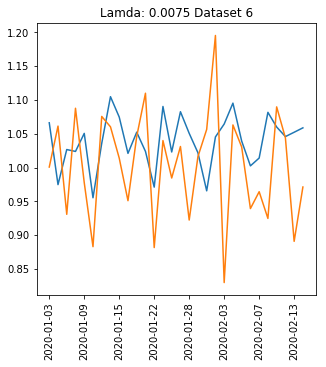

In [11]:
filepath = 'C:\\Users\\vivia\\Documents\\MRP\\News NLP\\Topic Model\\Datasets 0.75year_100topics\\'
dataset_type = "_0.75year"
i=5
get_prediction(filepath,dataset_type,num_topics = 100, alpha=0.0075)

In [10]:
#peaks defined as 0.5*stddev above/below the mean
filepath = 'C:\\Users\\vivia\\Documents\\MRP\\News NLP\\Topic Model\\Datasets 0.75year_100topics_2016-2017\\'
dataset_type = "_0.75year_2016"
i=0
get_metrics(filepath,dataset_type,num_topics = 100, alpha=0.0075)
i=3
get_metrics(filepath,dataset_type,num_topics = 100, alpha=0.0075)

Dataset1 RMSE: 0.157851
Dataset1 r2: 0.238776
Dataset1 non-zero coefficients:37

RMSE on test data 1 = 0.146022
Peaks Explained on test data 1 = 0.384615
Number of peaks on test data 1 13

Dataset4 RMSE: 0.147152
Dataset4 r2: 0.282868
Dataset4 non-zero coefficients:37

RMSE on test data 4 = 0.268374
Peaks Explained on test data 4 = 0.222222
Number of peaks on test data 4 9



RMSE on test data 1 = 0.146022


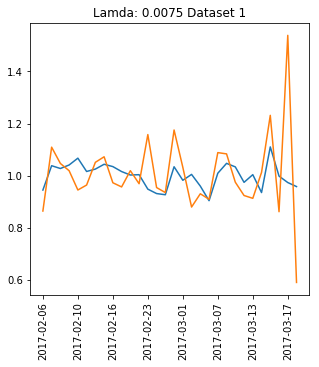

RMSE on test data 4 = 0.268374


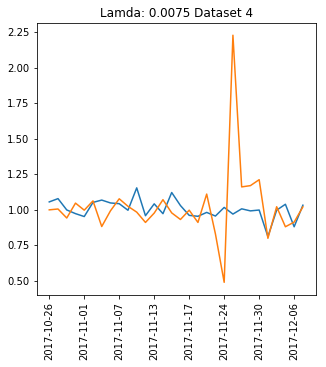

In [12]:
filepath = 'C:\\Users\\vivia\\Documents\\MRP\\News NLP\\Topic Model\\Datasets 0.75year_100topics_2016-2017\\'
dataset_type = "_0.75year_2016"
i=0
get_prediction(filepath,dataset_type,num_topics=100,alpha=0.0075)
i=3
get_prediction(filepath,dataset_type,num_topics=100,alpha=0.0075)

## Extract Top 8 Topics on Peak Days based on Topic Contribution on a Particular Day
- Topic Contribution calculated as topic coefficient * topic weight on based on articles on a particular day

In [ ]:
#load list of 100 topics extracted from LDA model
#Each topic is represented as a group of the top 10 most frequent words for that topic
from csv import reader

def get_topic_list(i):
    with  open(filepath+"topic_list"+str(i+1)+"_100topics.csv") as topics_file:
        csv_reader = reader(topics_file)
        topics_list=list(csv_reader)
    return topics_list

In [183]:
from pyspark.sql.types import FloatType
from matplotlib.ticker import (MultipleLocator, MaxNLocator)
def get_coefficients(filepath,dataset_type,num_topics, alpha):
    topicdist_file = "new_df"+str(i+1)+"_"+str(num_topics)+"topics.csv"
    ts_train_file = "df_train"+str(i+1)+dataset_type+".csv"
    ts_fcast_file = "pred_dataset"+str(i+1)+dataset_type+".csv"
    test_topicdist_file = "df_lm"+str(i+1)+".csv"
    
    
    df_topicdist = spark.read\
            .option("header",'true')\
            .csv(filepath+topicdist_file)
    df_fit = df_topicdist.groupBy(['date','change']).agg(collect_list("col").alias('topicDistribution'))
    
    #include avg change in dataframe with topic distribution
    df_ts = spark.read\
    .option("header",'true')\
    .csv(filepath+ts_train_file)
    df_ts = df_ts.select('date',exp("log_change").alias('Y_change'))    

    to_vect = udf(lambda vs: Vectors.dense(vs), VectorUDT())
    df_lm = df_fit.withColumn('topicDistribution',to_vect('topicDistribution')).select('date','change','topicDistribution')
    df_lm = df_lm.withColumn("change", df_lm["change"].cast(FloatType()))
    
    #fit regression model        
    lr=LinearRegression(featuresCol="topicDistribution", labelCol="change", maxIter=100,
    regParam=alpha, elasticNetParam=1.0)
    lr_model = lr.fit(df_lm)    
    
    #return model coefficients
    return lr_model.coefficients

In [261]:
i=0
filepath = 'C:\\Users\\vivia\\Documents\\MRP\\News NLP\\Topic Model\\Datasets 0.75year_100topics_2016-2017\\'
dataset_type="_0.75year"

#load LASSO regression predictions
df_pred =   spark.read\
            .option("header",'true')\
            .csv(filepath+"df_lm"+str(i+1)+"_pred.csv")
#load time series predictions
ts_pred_df =   spark.read\
            .option("header",'true')\
            .csv(filepath+"pred_dataset"+str(i+1)+dataset_type+"_2016.csv")
#conver time series predictions from log-change to change
r_pred_df = ts_pred_df.select("date",exp("Y_pred").alias("Y_pred"),exp('Y_test').alias("change"))

#load test dataset with topic distributions
df_lm_test =  spark.read\
            .option("header",'true')\
            .csv(filepath+"df_lm"+str(i+1)+".csv")
df_lm_test = df_lm_test.withColumn('col', df_lm_test["col"].cast(FloatType()))

#extract number of peaks explained, dates where the peaks are explained
df_peaks_explained,peaks_explained,num_peaks = calc_peaks_explained(df_pred,r_pred_df)


from pyspark.sql.window import Window
#get dates where the peaks are explained
dates_explained = [row['date'] for row in df_peaks_explained.where(col('count_explained')==1).select('date').collect()]
df_dates_explained = df_lm_test.select('date','col').where(col('date').isin(dates_explained))

coefficients = get_coefficients(filepath,dataset_type+"_2016",num_topics=100,alpha=0.0075)
#include coefficients for each row in the dataframe
df_coeff = df_dates_explained.select('date','col').groupBy('date').agg(collect_list('col').alias('topic_weight')).withColumn("coeff",array([lit(x) for x in coefficients]))
df_coeff=df_coeff.withColumn("coeff",df_coeff['coeff'].cast(ArrayType(FloatType()))) #convert to ArrayType
#calculate contribution of each topic as topic weight * coefficient
df_cont=df_coeff.withColumn(
    "contribution", 
    expr("transform(arrays_zip(topic_weight, coeff), x -> abs(x.topic_weight * x.coeff))")
) 

#rank contributions in descending order and get the top 8 indices of topics with the highest contribution
df_cont_explode = df_cont.select('date',explode('contribution').alias('cont'))
w1=Window.partitionBy('date').orderBy("date")
w2=Window.partitionBy('date').orderBy(col("cont").desc())
df_lm_test1 = df_cont_explode.select('date','cont').withColumn("index",row_number().over(w1)).withColumn("rank",rank().over(w2)).orderBy(col('date'),col('cont'),ascending=[1,0])\
               .where(col('rank')<=8)

#list of topics represented as a group of 10 words
topics_list = get_topic_list(i)


date_topic_distribution = df_dates_explained.select('date','col').groupBy('date').agg(collect_list('col').alias('topic_weight')).collect()
date_with_weight = df_lm_test1.select('date','index','cont').groupBy('date').agg(collect_list('cont').alias('cont')).collect()
#get top topic indices on peak days
date_with_idx = df_lm_test1.select('date','index').groupBy('date').agg(collect_list('index').alias('topic_index')).collect()
topic_idx_dict = {row['date']:row['topic_index'] for row in date_with_idx} #peak day date with index
topic_contribution_dict = {row['date']:row['cont'] for row in date_with_weight} #peak day date with contribution
topic_weight_dict = {row['date']:row['topic_weight'] for row in date_topic_distribution} #peak day date with topic weight

#based on topic index, extract actual topic from topic list
topic_dict={}
for k,v in topic_idx_dict.items():
    topics=[]
    i=0
    for idx in v:
        cont=topic_contribution_dict[k][i]
        topics += [topics_list[idx-1]],topic_weight_dict[k][idx-1]*coefficients[idx-1]
        i+=1
    topic_dict[k]=topics

#export topics for report
i=1
with open('result'+str(i)+'.json', 'w') as fp:
    json.dump(topic_dict, fp)

In [262]:
i=3
filepath = 'C:\\Users\\vivia\\Documents\\MRP\\News NLP\\Topic Model\\Datasets 0.75year_100topics_2016-2017\\'
dataset_type="_0.75year"

#load LASSO regression predictions
df_pred =   spark.read\
            .option("header",'true')\
            .csv(filepath+"df_lm"+str(i+1)+"_pred.csv")
#load time series predictions
ts_pred_df =   spark.read\
            .option("header",'true')\
            .csv(filepath+"pred_dataset"+str(i+1)+dataset_type+"_2016.csv")
#conver time series predictions from log-change to change
r_pred_df = ts_pred_df.select("date",exp("Y_pred").alias("Y_pred"),exp('Y_test').alias("change"))

#load test dataset with topic distributions
df_lm_test =  spark.read\
            .option("header",'true')\
            .csv(filepath+"df_lm"+str(i+1)+".csv")
df_lm_test = df_lm_test.withColumn('col', df_lm_test["col"].cast(FloatType()))

#extract number of peaks explained, dates where the peaks are explained
df_peaks_explained,peaks_explained,num_peaks = calc_peaks_explained(df_pred,r_pred_df)


from pyspark.sql.window import Window
#get dates where the peaks are explained
dates_explained = [row['date'] for row in df_peaks_explained.where(col('count_explained')==1).select('date').collect()]
df_dates_explained = df_lm_test.select('date','col').where(col('date').isin(dates_explained))

coefficients = get_coefficients(filepath,dataset_type+"_2016",num_topics=100,alpha=0.0075)
#include coefficients for each row in the dataframe
df_coeff = df_dates_explained.select('date','col').groupBy('date').agg(collect_list('col').alias('topic_weight')).withColumn("coeff",array([lit(x) for x in coefficients]))
df_coeff=df_coeff.withColumn("coeff",df_coeff['coeff'].cast(ArrayType(FloatType()))) #convert to ArrayType
#calculate contribution of each topic as topic weight * coefficient
df_cont=df_coeff.withColumn(
    "contribution", 
    expr("transform(arrays_zip(topic_weight, coeff), x -> abs(x.topic_weight * x.coeff))")
) 

#rank contributions in descending order and get the top 8 indices of topics with the highest contribution
df_cont_explode = df_cont.select('date',explode('contribution').alias('cont'))
w1=Window.partitionBy('date').orderBy("date")
w2=Window.partitionBy('date').orderBy(col("cont").desc())
df_lm_test1 = df_cont_explode.select('date','cont').withColumn("index",row_number().over(w1)).withColumn("rank",rank().over(w2)).orderBy(col('date'),col('cont'),ascending=[1,0])\
               .where(col('rank')<=8)

#list of topics represented as a group of 10 words
topics_list = get_topic_list(i)


date_topic_distribution = df_dates_explained.select('date','col').groupBy('date').agg(collect_list('col').alias('topic_weight')).collect()
date_with_weight = df_lm_test1.select('date','index','cont').groupBy('date').agg(collect_list('cont').alias('cont')).collect()
#get top topic indices on peak days
date_with_idx = df_lm_test1.select('date','index').groupBy('date').agg(collect_list('index').alias('topic_index')).collect()
topic_idx_dict = {row['date']:row['topic_index'] for row in date_with_idx} #peak day date with index
topic_contribution_dict = {row['date']:row['cont'] for row in date_with_weight} #peak day date with contribution
topic_weight_dict = {row['date']:row['topic_weight'] for row in date_topic_distribution} #peak day date with topic weight

#based on topic index, extract actual topic from topic list
topic_dict={}
for k,v in topic_idx_dict.items():
    topics=[]
    i=0
    for idx in v:
        cont=topic_contribution_dict[k][i]
        topics += [topics_list[idx-1]],topic_weight_dict[k][idx-1]*coefficients[idx-1]
        i+=1
    topic_dict[k]=topics

#export topics for report
i=3
with open('result'+str(i+1)+'.json', 'w') as fp:
    json.dump(topic_dict, fp)

In [263]:
i=5
filepath = 'C:\\Users\\vivia\\Documents\\MRP\\News NLP\\Topic Model\\Datasets 0.75year_100topics\\'
dataset_type="_0.75year"

#load LASSO regression predictions
df_pred =   spark.read\
            .option("header",'true')\
            .csv(filepath+"df_lm"+str(i+1)+"_pred.csv")
#load time series predictions
ts_pred_df =   spark.read\
            .option("header",'true')\
            .csv(filepath+"pred_dataset"+str(i+1)+dataset_type+"_2016.csv")
#conver time series predictions from log-change to change
r_pred_df = ts_pred_df.select("date",exp("Y_pred").alias("Y_pred"),exp('Y_test').alias("change"))

#load test dataset with topic distributions
df_lm_test =  spark.read\
            .option("header",'true')\
            .csv(filepath+"df_lm"+str(i+1)+".csv")
df_lm_test = df_lm_test.withColumn('col', df_lm_test["col"].cast(FloatType()))

#extract number of peaks explained, dates where the peaks are explained
df_peaks_explained,peaks_explained,num_peaks = calc_peaks_explained(df_pred,r_pred_df)


from pyspark.sql.window import Window
#get dates where the peaks are explained
dates_explained = [row['date'] for row in df_peaks_explained.where(col('count_explained')==1).select('date').collect()]
df_dates_explained = df_lm_test.select('date','col').where(col('date').isin(dates_explained))

coefficients = get_coefficients(filepath,dataset_type+"_2016",num_topics=100,alpha=0.0075)
#include coefficients for each row in the dataframe
df_coeff = df_dates_explained.select('date','col').groupBy('date').agg(collect_list('col').alias('topic_weight')).withColumn("coeff",array([lit(x) for x in coefficients]))
df_coeff=df_coeff.withColumn("coeff",df_coeff['coeff'].cast(ArrayType(FloatType()))) #convert to ArrayType
#calculate contribution of each topic as topic weight * coefficient
df_cont=df_coeff.withColumn(
    "contribution", 
    expr("transform(arrays_zip(topic_weight, coeff), x -> abs(x.topic_weight * x.coeff))")
) 

#rank contributions in descending order and get the top 8 indices of topics with the highest contribution
df_cont_explode = df_cont.select('date',explode('contribution').alias('cont'))
w1=Window.partitionBy('date').orderBy("date")
w2=Window.partitionBy('date').orderBy(col("cont").desc())
df_lm_test1 = df_cont_explode.select('date','cont').withColumn("index",row_number().over(w1)).withColumn("rank",rank().over(w2)).orderBy(col('date'),col('cont'),ascending=[1,0])\
               .where(col('rank')<=8)

#list of topics represented as a group of 10 words
topics_list = get_topic_list(i)


date_topic_distribution = df_dates_explained.select('date','col').groupBy('date').agg(collect_list('col').alias('topic_weight')).collect()
date_with_weight = df_lm_test1.select('date','index','cont').groupBy('date').agg(collect_list('cont').alias('cont')).collect()
#get top topic indices on peak days
date_with_idx = df_lm_test1.select('date','index').groupBy('date').agg(collect_list('index').alias('topic_index')).collect()
topic_idx_dict = {row['date']:row['topic_index'] for row in date_with_idx} #peak day date with index
topic_contribution_dict = {row['date']:row['cont'] for row in date_with_weight} #peak day date with contribution
topic_weight_dict = {row['date']:row['topic_weight'] for row in date_topic_distribution} #peak day date with topic weight

#based on topic index, extract actual topic from topic list
topic_dict={}
for k,v in topic_idx_dict.items():
    topics=[]
    i=0
    for idx in v:
        cont=topic_contribution_dict[k][i]
        topics += [topics_list[idx-1]],topic_weight_dict[k][idx-1]*coefficients[idx-1]
        i+=1
    topic_dict[k]=topics

#export topics for report
i=2
with open('result'+str(i+1)+'.json', 'w') as fp:
    json.dump(topic_dict, fp)

## Plot Predictions

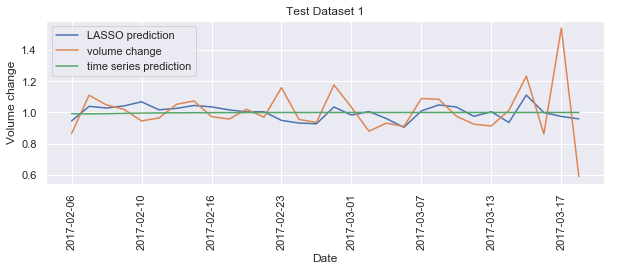

In [314]:
i=0
filepath = 'C:\\Users\\vivia\\Documents\\MRP\\News NLP\\Topic Model\\Datasets 0.75year_100topics_2016-2017\\'
dataset_type="_0.75year"
df_pred =   spark.read\
            .option("header",'true')\
            .csv(filepath+"df_lm"+str(i+1)+"_pred.csv")
ts_pred_df =   spark.read\
            .option("header",'true')\
            .csv(filepath+"pred_dataset"+str(i+1)+dataset_type+"_2016.csv")
r_pred_df = ts_pred_df.select("date",exp("Y_pred").alias("time series prediction"),exp('Y_test').alias("change"))

plot_predictions(df_pred,r_pred_df,test_set_num = 1)




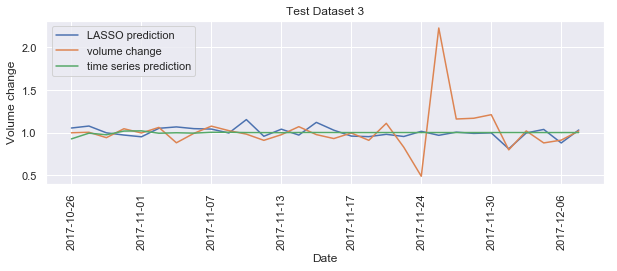

In [315]:
i=3
filepath = 'C:\\Users\\vivia\\Documents\\MRP\\News NLP\\Topic Model\\Datasets 0.75year_100topics_2016-2017\\'
dataset_type="_0.75year"
df_pred =   spark.read\
            .option("header",'true')\
            .csv(filepath+"df_lm"+str(i+1)+"_pred.csv")
ts_pred_df =   spark.read\
            .option("header",'true')\
            .csv(filepath+"pred_dataset"+str(i+1)+dataset_type+"_2016.csv")
r_pred_df = ts_pred_df.select("date",exp("Y_pred").alias("time series prediction"),exp('Y_test').alias("change"))

plot_predictions(df_pred,r_pred_df,test_set_num = 3)



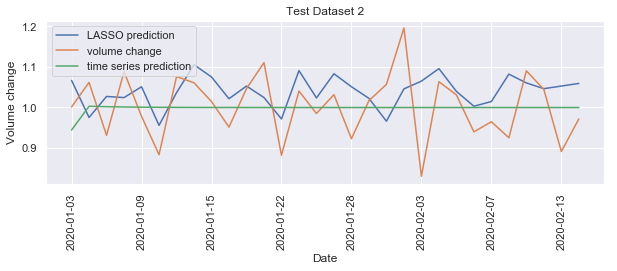

In [316]:
i=5
filepath = 'C:\\Users\\vivia\\Documents\\MRP\\News NLP\\Topic Model\\Datasets 0.75year_100topics\\'
dataset_type="_0.75year"
df_pred =   spark.read\
            .option("header",'true')\
            .csv(filepath+"df_lm"+str(i+1)+"_pred.csv")
ts_pred_df =   spark.read\
            .option("header",'true')\
            .csv(filepath+"pred_dataset"+str(i+1)+dataset_type+".csv")
r_pred_df = ts_pred_df.select("date",exp("Y_pred").alias("time series prediction"),exp('Y_test').alias("change"))

plot_predictions(df_pred,r_pred_df,test_set_num = 2)



In [2]:
def plot_ts(df_ts,test_set_num):
    r_pred_df = df_ts.select("date",exp("Y_pred").alias("time series prediction"),exp('Y_test').alias("change"),exp("Lower_CI").alias("lower bound"),exp("Upper_CI").alias("upper bound"))
   # r_pred_df = df_ts.select("date","Y_pred",'Y_test',"Lower_CI","Upper_CI")
    r_pred_df = r_pred_df.select("*").toPandas()
#     r_pred_df['Y_test'] = r_pred_df['Y_test'].astype('float64')
#     r_pred_df['Y_pred'] = r_pred_df['Y_pred'].astype('float32')
#     r_pred_df['Upper_CI'] = r_pred_df['Upper_CI'].astype('float32')
#     r_pred_df['Lower_CI'] = r_pred_df['Lower_CI'].astype('float32')
    df_plot = r_pred_df.sort_values('date').reset_index().drop(columns='index')
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.xaxis.set_major_locator(MaxNLocator())
    plt.xticks(rotation=90)
    plt.xlabel('Date')
    plt.ylabel('Volume change')
    ax.plot(df_plot['date'],df_plot['lower bound'])
    ax.plot(df_plot['date'],df_plot['upper bound'])
    ax.plot(df_plot['date'],df_plot['change'])
    ax.plot(df_plot['date'],df_plot['time series prediction'])
#     ax.plot(df_plot['date'],df_plot['Lower_CI'])
#     ax.plot(df_plot['date'],df_plot['Upper_CI'])
#     ax.plot(df_plot['date'],df_plot['Y_test'])
#     ax.plot(df_plot['date'],df_plot['Y_pred'])
    ax.legend(loc='upper left')
    sns.set()
    #    plt.plot(df_plot['date'],df_plot['ts_pred'])
    plt.title("Test Dataset "+str(test_set_num))
    plt.show()
  
    

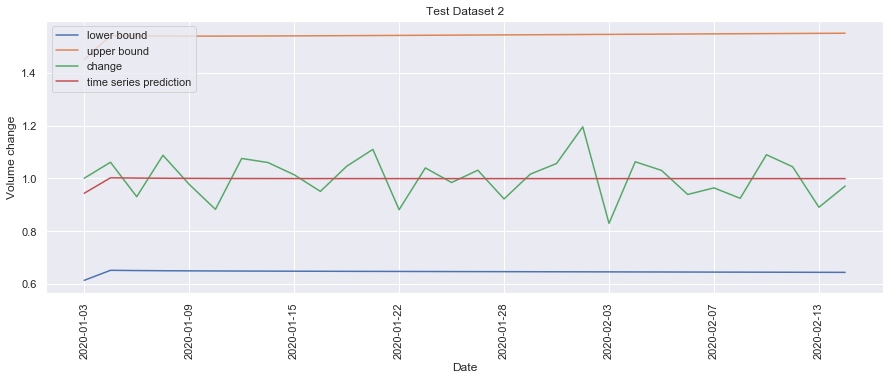

In [289]:
i=5
filepath = 'C:\\Users\\vivia\\Documents\\MRP\\News NLP\\Topic Model\\Datasets 0.75year_100topics\\'
dataset_type="_0.75year"

ts_pred_df =   spark.read\
            .option("header",'true')\
            .csv(filepath+"pred_dataset"+str(i+1)+dataset_type+".csv")

plot_ts(ts_pred_df,test_set_num = 2)

